In [5]:
import numpy as np

import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.4.0
Eager mode:  True
Hub version:  0.11.0
GPU is NOT AVAILABLE


In [6]:
dataset = pd.read_json('../datasets/archive_npl/Sarcasm_Headlines_Dataset.json', lines=True)
dataset.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [8]:
X = dataset['headline']
y = dataset['is_sarcastic']
train_examples,test_examples, train_labels, test_labels = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 17895, test entries: 8814


In [12]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.04816968,  0.18182401,  0.01232709,  0.15525866, -0.14094536,
         0.07831184, -0.00332468,  0.00274877, -0.25921625,  0.11529584,
         0.122819  , -0.04108253,  0.0653303 ,  0.0385872 , -0.04277446,
        -0.11273344, -0.13166021,  0.11089256,  0.10727907, -0.06375621,
        -0.09129177, -0.02591852,  0.2502565 , -0.3272279 ,  0.14941633,
         0.18393007, -0.18135807,  0.02115635,  0.02927185, -0.22391321,
         0.26373002, -0.01004327,  0.13471922, -0.11499519, -0.08508932,
         0.10049979,  0.11711608, -0.19087046, -0.11922717, -0.19074474,
         0.08824456, -0.06403164, -0.03454276, -0.13272382, -0.14498934,
        -0.05114302,  0.00248443,  0.03040618,  0.17980222,  0.01677975],
       [ 0.32180154, -0.2980637 ,  0.02769545, -0.18873535, -0.15348655,
         0.11514136, -0.05171264,  0.01228407, -0.03199307, -0.07574848,
        -0.00629165,  0.0316075 ,  0.1289413 ,  0.02444617, -0.09028083,
 

In [13]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [19]:
history = model.fit(train_examples,
                    train_labels,
                    epochs=5,
                    batch_size=512,
                    validation_data=(test_examples, test_labels),
                    verbose=1)

Epoch 1/5
35/35 [==============================] - 36s 1s/step - loss: 0.6803 - accuracy: 0.5584 - val_loss: 0.6359 - val_accuracy: 0.6629
Epoch 2/5
35/35 [==============================] - 34s 976ms/step - loss: 0.6019 - accuracy: 0.7232 - val_loss: 0.5362 - val_accuracy: 0.7899
Epoch 3/5
35/35 [==============================] - 35s 991ms/step - loss: 0.4695 - accuracy: 0.8604 - val_loss: 0.4160 - val_accuracy: 0.8378
Epoch 4/5
35/35 [==============================] - 35s 1s/step - loss: 0.3215 - accuracy: 0.9025 - val_loss: 0.3533 - val_accuracy: 0.8501
Epoch 5/5
35/35 [==============================] - 35s 1s/step - loss: 0.2257 - accuracy: 0.9305 - val_loss: 0.3367 - val_accuracy: 0.8534


In [21]:
results = model.evaluate(test_examples, test_labels)

print(results)

276/276 [==============================] - 0s 2ms/step - loss: 0.3367 - accuracy: 0.8534
[0.33667322993278503, 0.8534150123596191]


In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

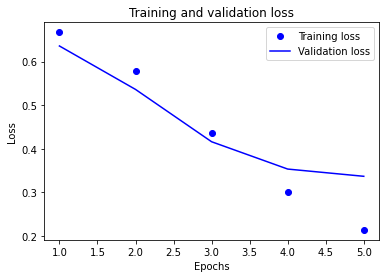

In [23]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

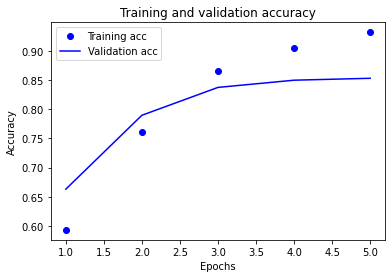

In [24]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()